# Yorkeys Knob

In [13]:
from os import path
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
import warnings
warnings.filterwarnings("ignore")


In [14]:
(ID, RID) = ('YKN', 0)
# Output folder ---------------------------------------------------------------
OUT_PTH = './sims_out/'
srv.makeFolder(OUT_PTH)

## Landscape

In [15]:
LND_PTH = './GEO/{}_LatLon.csv'.format(ID)
YK_LL = pd.read_csv(LND_PTH, names=['lon', 'lat'])
YK_LL['t'] = [0]*YK_LL.shape[0]
pad = 0.00125
YK_BBOX = (
    (min(YK_LL['lon'])-pad, max(YK_LL['lon'])+pad),
    (min(YK_LL['lat'])-pad, max(YK_LL['lat'])+pad)
)

In [16]:
mKer = {
    'kernelFunction': srv.zeroInflatedExponentialKernel,
    'kernelParams': {'params': srv.AEDES_EXP_PARAMS, 'zeroInflation': 1-0.28}
}

In [17]:
TRAP_TYP = [0]*8 + [1]*8
TRPS_NUM = len(TRAP_TYP)
nullTraps = [0]*TRPS_NUM
cntr = ([np.mean(YK_LL['lon'])]*TRPS_NUM, [np.mean(YK_LL['lat'])]*TRPS_NUM)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid,
    'lon': cntr[0], 'lat': cntr[1], 
    't': TRAP_TYP, 'f': nullTraps
})

In [18]:
# Setup trap kernels ----------------------------------------------------------
tKer = {
    1: {
        'kernel': srv.sigmoidDecay,     
        'params': {'A': 0.5, 'rate': .25, 'x0': 1/0.0629534}
    },
    0: {
        'kernel': srv.exponentialDecay, 
        'params': {'A': 0.5, 'b': 0.0629534}
    }
}

In [32]:
lnd = srv.Landscape(
    YK_LL, 
    kernelFunction=mKer['kernelFunction'], kernelParams=mKer['kernelParams'],
    traps=traps, trapsKernels=tKer, trapsRadii=[0.250, 0.125, 0.100],
    landLimits=YK_BBOX
)
bbox = lnd.getBoundingBox()

(<Figure size 1500x1500 with 1 Axes>, <GeoAxes: >)

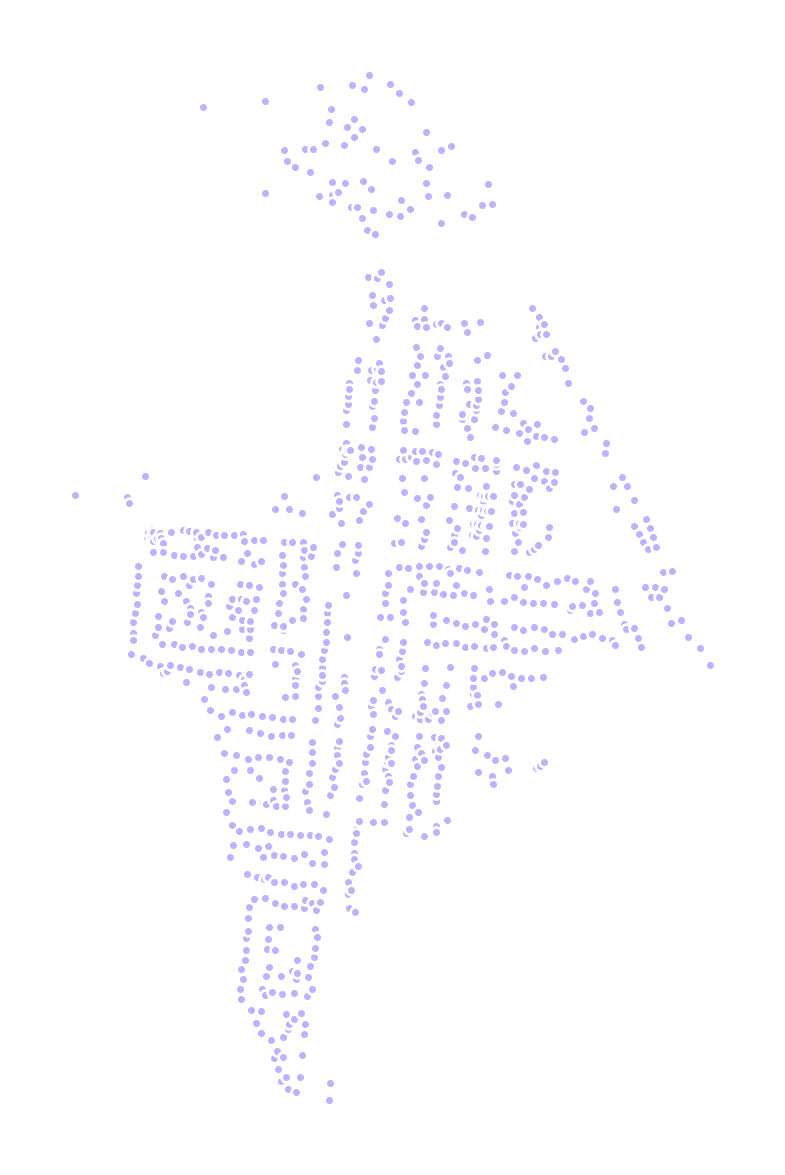

In [33]:
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.plotSites(fig, ax, size=50)
srv.plotClean(fig, ax, bbox=lnd.landLimits)

## Optimization

### Discrete

In [20]:
(GENS, GA_SUMSTAT, VERBOSE) = (100, np.mean, True)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': .3, 'indpb': 0.5}, 
    {'mutpb': .4, 'indpb': 0.5},
    {'tSize': 4}
)

In [29]:
(lnd, logbook) = srv.optimizeDiscreteTrapsGA(
    lnd, verbose=VERBOSE, generations=GENS, pop_size=POP_SIZE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

gen	nevals	min    	avg    	max    	std    	best	traps                                                                         
0  	200   	94.9749	136.084	198.401	20.4587	135 	[636, 153, 339, 566, 718, 809, 219, 58, 864, 470, 912, 242, 66, 276, 602, 884]
1  	123   	94.9749	123.05 	192.857	13.9826	71  	[636, 153, 339, 566, 718, 809, 219, 58, 864, 470, 912, 242, 66, 276, 602, 884]
2  	121   	91.0214	116.961	171.979	13.4313	141 	[713, 252, 829, 519, 149, 102, 732, 581, 664, 355, 428, 674, 7, 195, 494, 233]
3  	111   	92.9962	112.774	196.544	14.2054	32  	[594, 110, 376, 519, 149, 102, 732, 274, 583, 355, 168, 713, 32, 690, 713, 233]
4  	126   	91.2235	109.749	170.684	13.6874	77  	[509, 20, 721, 701, 302, 428, 526, 674, 719, 254, 757, 247, 137, 636, 778, 744]
5  	118   	83.5076	107.52 	173.24 	14.0667	175 	[594, 20, 376, 519, 149, 102, 732, 201, 583, 355, 761, 713, 32, 690, 898, 233] 
6  	110   	82.4909	104.582	182.727	15.4959	128 	[713, 552, 448, 18, 108, 806, 732, 292, 327, 18, 353, 912, 7

### Continuous

In [34]:
(GENS, GA_SUMSTAT, VERBOSE) = (100, np.mean, True)
# Parameters for the genetic algorithm internal operation ---------------------
POP_SIZE = int(10*(lnd.trapsNumber*1.25))
(MAT, MUT, SEL) = (
    {'cxpb': 0.5, 'alpha': 0.5}, 
    {'mean': 0, 'sd': 0.0025, 'mutpb': .4, 'ipb': .5},
    {'tSize': 3}
)
# Bounding box for traps position sampling ------------------------------------
delta=0.000015
dPad = (
    (bbox[0][0]*(1+delta), bbox[0][1]*(1-delta)), 
    (bbox[1][0]*(1-delta*20), bbox[1][1]*(1+delta*20))
)

In [35]:
(lnd, logbook) = srv.optimizeTrapsGA(
    lnd, verbose=VERBOSE,
    bbox=dPad, pop_size=POP_SIZE, generations=GENS,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': GA_SUMSTAT}
)
srv.exportLog(logbook, OUT_PTH, '{}D-{:02d}-{:02d}_LOG'.format(ID, TRPS_NUM, RID))
srv.dumpLandscape(lnd, OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), fExt='pkl')

gen	nevals	min    	avg    	max   	std    	best	traps                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
0  	200   	138.047	237.734	463.94	55.0973	199 	[145.72098478428413, -16.809646395955212, 145.72391287019911, -16.809121921351817, 145.72307190864228, -16.80997555376296, 145.72169782933986, -16.814021693907765, 145.72207016985539, -16.807158974146645, 145.71969066923947, -16.815673058446247, 145.7184766187

## Analysis

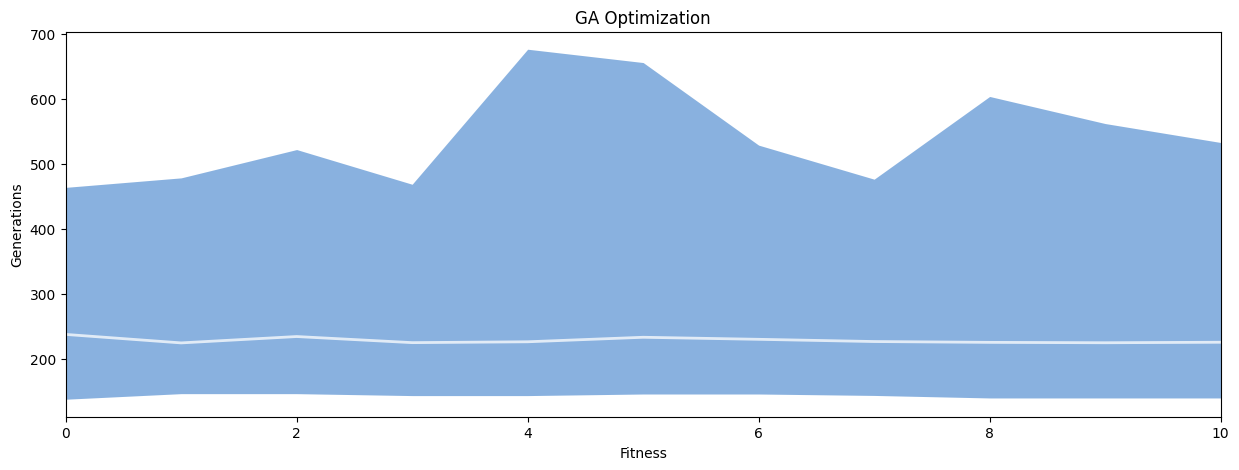

In [36]:
log = pd.DataFrame(logbook)
log.rename(columns={'median': 'avg'}, inplace=True)
(fig, ax) = plt.subplots(1, 1, figsize=(15, 5), sharey=False)
ax.set_title("GA Optimization")
ax.set_xlabel("Fitness")
ax.set_ylabel("Generations")
srv.plotGAEvolution(
    fig, ax, log,
    colors={'mean': '#ffffff', 'envelope': '#1565c0'},
    alphas={'mean': .75, 'envelope': 0.5},
    aspect=1/3
)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_GA.png'.format(ID, TRPS_NUM, RID)),  
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=300
)

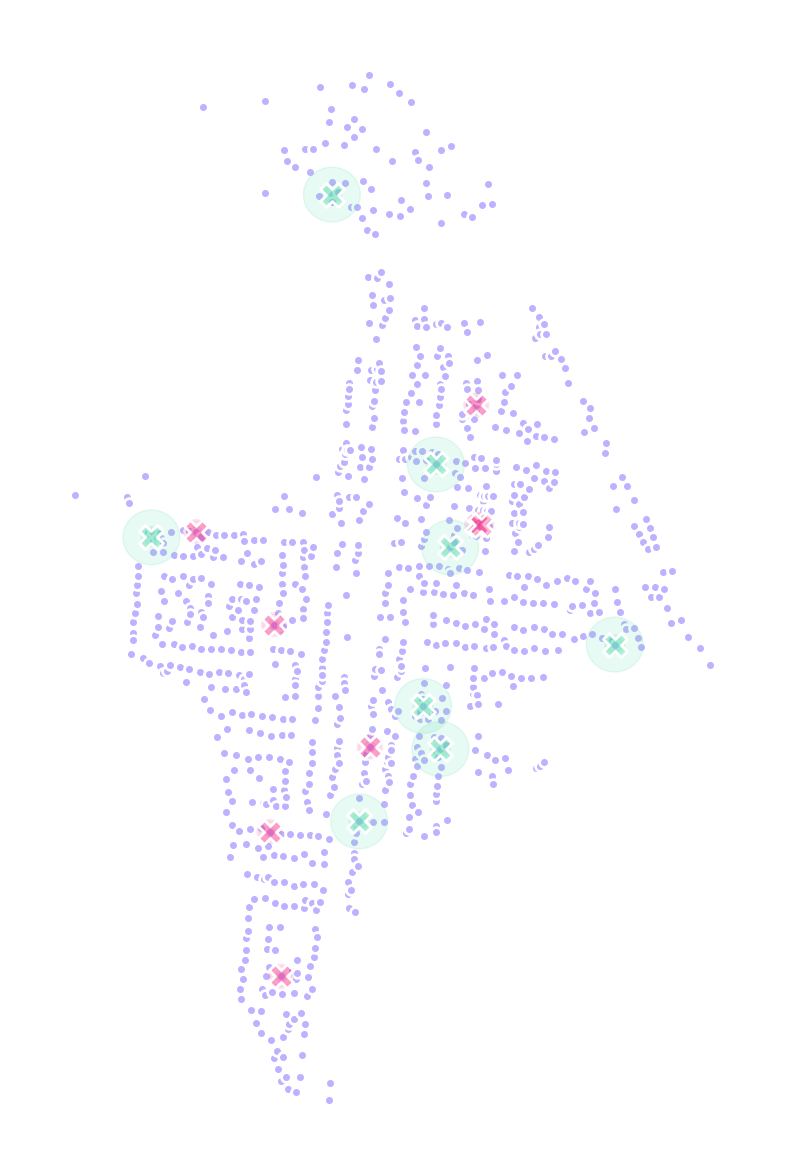

In [37]:
lnd = srv.loadLandscape(
    OUT_PTH, '{}D-{:02d}-{:02d}_TRP'.format(ID, TRPS_NUM, RID), 
    fExt='pkl'
)
(fig, ax) = (
    plt.figure(figsize=(15, 15)),
    plt.axes(projection=ccrs.PlateCarree())
)
lnd.updateTrapsRadii([0.250, 0.125, 0.100])
lnd.plotSites(fig, ax, size=50)
lnd.plotTraps(
    fig, ax, 
    zorders=(30, 25), transparencyHex='55', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=lnd.landLimits)
fig.savefig(
    path.join(OUT_PTH, '{}D-{:02d}-{:02d}_TRP.png'.format(ID, TRPS_NUM, RID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=400
)